### Preliminary Model (WSDM-KKBox Churn Prediction)

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.style.use('ggplot')
import re

** We're running our predictive model on data that we've further pre-processed with Alteryx Designer **

[Business Problem & EDA Notebook here](descriptive_data_discovery.ipynb)

In [2]:
data = pd.read_csv('train_dataset.csv')
data.head()

,msno,is_churn,city,bd,gender,registered_via,member_days,no_of_transactions,no_of_cancellations,cancelled,...,plan_days_110,plan_days_200,plan_days_230,plan_days_240,plan_days_270,plan_days_360,plan_days_365,plan_days_395,plan_days_400,plan_days_450
0,+++hVY1rZox/33YtvDgmKA2Frg/2qhkz12B9ylCvh8o=,0,1.0,0.0,missing,7.0,1195.0,4,0,0,...,0,0,0,0,0,0,0,0,0,0
1,+++l/EXNMLTijfLBa8p2TUVVVp2aFGSuUI/h7mLmthw=,0,15.0,26.0,male,9.0,2527.0,19,0,0,...,0,0,0,0,0,0,0,0,0,0
2,+++snpr7pmobhLKUgSHTv/mpkqgBT0tQJ0zQj6qKrqc=,0,1.0,0.0,missing,7.0,1099.0,26,0,0,...,0,0,0,0,0,0,0,0,0,0
3,++/9R3sX37CjxbY/AaGvbwr3QkwElKBCtSvVzhCBDOk=,0,18.0,21.0,male,7.0,571.0,12,0,0,...,0,0,0,0,0,0,0,0,0,0
4,++/UDNo9DLrxT8QVGiDi1OnWfczAdEwThaVyD0fXO50=,0,22.0,32.0,male,9.0,2101.0,19,0,0,...,0,0,0,0,0,0,0,0,0,0


### Model Assumptions

- Is it a fair assumption to expect city to be a heavy predictor simply because most subscribers are from one city?
    - Is this a form of feature bias?

- 

In [3]:
# subset of independent variables that we will assume weigh heavily on churn

members = ['city', 'bd', 'gender', 'registered_via', 'member_days', 'no_of_transactions', 'no_of_cancellations', 'cancelled']

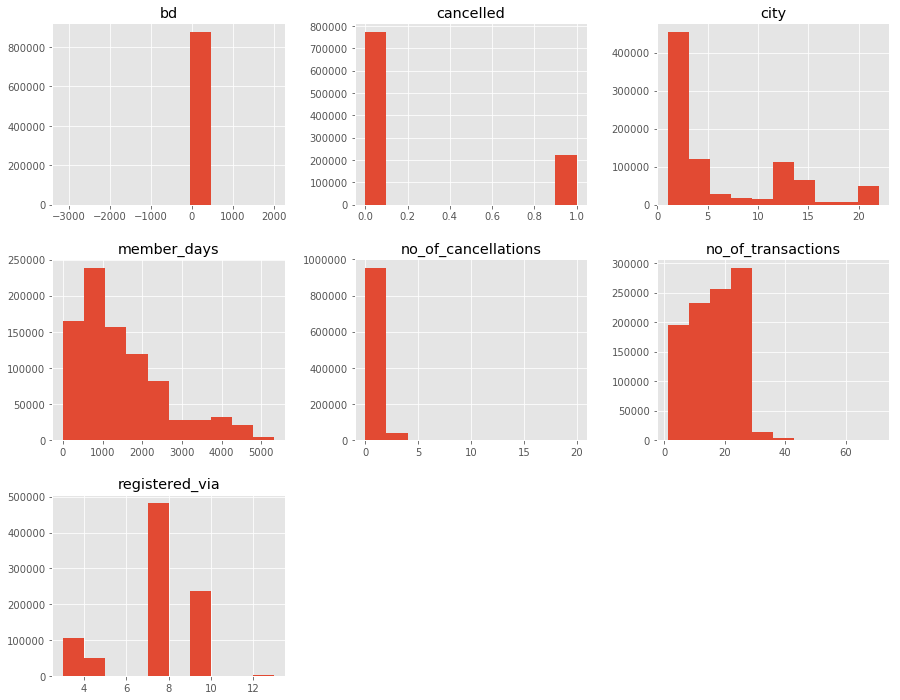

In [4]:
data[members].hist(bins=10, figsize=(15,12))
plt.show()

In [5]:
for col in data.columns[:13]:
    print col

msno
is_churn
city
bd
gender
registered_via
member_days
no_of_transactions
no_of_cancellations
cancelled
total_amount_paid
is_auto_renew
payment_method_14


In [6]:
# searching for null values after merging datasets

data.columns[data.isnull().any()]

Index([u'city', u'bd', u'gender', u'registered_via', u'member_days'], dtype='object')

### The Strategy for Null Values and Its Anticipated Effect on Our Model

- The imputer strategy we adopt depends heavily on the nature of the feature in question
- 

In [7]:
# the bd variable is very messy. it consists of negative numbers and some seemingly impossible ages (> 100)...

print data['bd'][(data['bd'] < 0)].count()
data['bd'][(data['bd']) > 80].count()

72


667

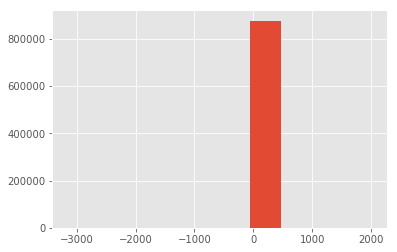

In [8]:
data['bd'].hist()
plt.show()

In [9]:
data.loc[data['gender'] == 'missing', 'gender'] = np.nan
data.loc[data['bd'] < 0, 'bd'] = np.nan
data.loc[data['bd'] > 80, 'bd'] = np.nan

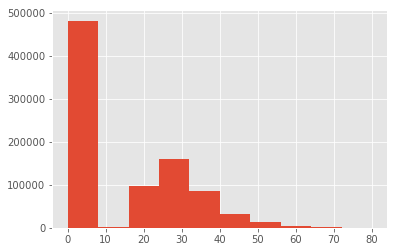

In [10]:
data['bd'].hist()
plt.show()

In [11]:
print data['bd'][(data['bd']) < 10].count()
data['bd'][(data['bd']) < 5].count()

481293


481230

In [12]:
data.loc[data['bd'] < 10, 'bd'] = np.nan

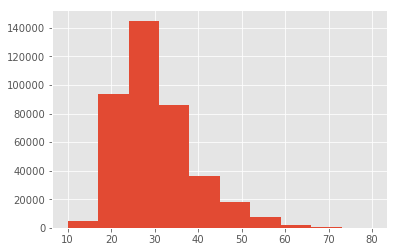

In [13]:
data['bd'].hist()
plt.show()

In [14]:
float(data['bd'].count())*100/len(data['bd'])

39.69168048937942

In [15]:
# What is the distribution of our target variable?

churn_length = data['is_churn'][(data['is_churn'] == 1)].count()
# print data['is_churn'][(data['is_churn'] == 0)].count()
print float(churn_length)/len(data['is_churn']) * 100

6.39228707735


< 6.5% of our target indicates churn

In [16]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, precision_recall_curve, f1_score
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.preprocessing import Imputer

### N.B. We should define functions to automate data transformation

In [17]:
from sklearn.base import TransformerMixin

class DataFrameImputer(TransformerMixin):
    
    def __init__(self):
        """Impute missing values.
        
        Columns of dtype object are imputed with the most frequent value in column.
        
        Columns of other types are imputed with median of column.
        
        """
    def fit(self, X, y=None):
        
        self.fill = pd.Series([X[c].value_counts().index[0]
            if X[c].dtype == np.dtype('O') else X[c].median() for c in X],
                index=X.columns)
        
        return self
    
    def transform(self, X, y=None):
        return X.fillna(self.fill)

In [18]:
lst = ['city', 'bd', 'gender', 'registered_via', 'member_days', 'no_of_transactions', 'no_of_cancellations', 'cancelled', 'total_amount_paid', 'is_auto_renew']
cat_cols = ['city', 'registered_via', 'gender', 'is_auto_renew', 'cancelled']
int_cols = ['bd', 'member_days', 'no_of_transactions', 'no_of cancellations']

data[lst] = DataFrameImputer().fit_transform(data[lst])

In [19]:
from collections import defaultdict
d = defaultdict(LabelEncoder)

fit = data[cat_cols].apply(lambda x: d[x.name].fit(x))
data[cat_cols] = data[cat_cols].apply(lambda x: d[x.name].transform(x))

In [20]:
data.head(15)

,msno,is_churn,city,bd,gender,registered_via,member_days,no_of_transactions,no_of_cancellations,cancelled,...,plan_days_110,plan_days_200,plan_days_230,plan_days_240,plan_days_270,plan_days_360,plan_days_365,plan_days_395,plan_days_400,plan_days_450
0,+++hVY1rZox/33YtvDgmKA2Frg/2qhkz12B9ylCvh8o=,0,0,28.0,1,2,1195.0,4,0,0,...,0,0,0,0,0,0,0,0,0,0
1,+++l/EXNMLTijfLBa8p2TUVVVp2aFGSuUI/h7mLmthw=,0,13,26.0,1,3,2527.0,19,0,0,...,0,0,0,0,0,0,0,0,0,0
2,+++snpr7pmobhLKUgSHTv/mpkqgBT0tQJ0zQj6qKrqc=,0,0,28.0,1,2,1099.0,26,0,0,...,0,0,0,0,0,0,0,0,0,0
3,++/9R3sX37CjxbY/AaGvbwr3QkwElKBCtSvVzhCBDOk=,0,16,21.0,1,2,571.0,12,0,0,...,0,0,0,0,0,0,0,0,0,0
4,++/UDNo9DLrxT8QVGiDi1OnWfczAdEwThaVyD0fXO50=,0,20,32.0,1,3,2101.0,19,0,0,...,0,0,0,0,0,0,0,0,0,0
5,++/ZHqwUNa7U21Qz+zqteiXlZapxey86l6eEorrak/g=,0,11,39.0,1,0,1087.0,21,0,0,...,0,0,0,0,0,0,0,0,0,0
6,++0/NopttBsaAn6qHZA2AWWrDg7Me7UOMs1vsyo4tSI=,0,0,28.0,1,2,549.0,12,0,0,...,0,0,0,0,0,0,0,0,0,0
7,++0BJXY8tpirgIhJR14LDM1pnaRosjD1mdO1mIKxlJA=,0,0,28.0,1,3,784.0,16,0,0,...,0,0,0,0,0,0,0,0,0,0
8,++0EzISdtKY48Z0GY62jer/LFQwrNIAbADdtU5xStGY=,0,0,28.0,1,0,1401.0,6,0,0,...,0,0,0,0,0,0,0,0,0,0
9,++0wqjjQge1mBBe5r4ciHGKwtF/m322zkra7CK8I+Mw=,0,0,28.0,1,2,1215.0,16,0,0,...,0,0,0,0,0,0,0,0,0,0


In [21]:
'''def xfrom_null(df):
    cols = ['city', 'registered_via', 'gender', 'is_auto_renew', 'cancelled']
    for col in cols:
        df[col] = df[col].fillna('missing')
    return df
        
def to_cat(df):
    cols = ['city', 'registered_via', 'gender', 'is_auto_renew', 'cancelled']
    for col in cols:
        df[col] = df[col].astype('category')
    return df

def scale_f(df, scaler=MinMaxScaler()):
    to_scale = ['bd', 'member_days', 'no_of_transactions', 'no_of_cancellations', 'no_of_transactions', 'total_amount_paid']
    df[to_scale] = scaler.fit_transform(df[to_scale])
    return df
    '''

"def xfrom_null(df):\n    cols = ['city', 'registered_via', 'gender', 'is_auto_renew', 'cancelled']\n    for col in cols:\n        df[col] = df[col].fillna('missing')\n    return df\n        \ndef to_cat(df):\n    cols = ['city', 'registered_via', 'gender', 'is_auto_renew', 'cancelled']\n    for col in cols:\n        df[col] = df[col].astype('category')\n    return df\n\ndef scale_f(df, scaler=MinMaxScaler()):\n    to_scale = ['bd', 'member_days', 'no_of_transactions', 'no_of_cancellations', 'no_of_transactions', 'total_amount_paid']\n    df[to_scale] = scaler.fit_transform(df[to_scale])\n    return df\n    "

In [22]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 992931 entries, 0 to 992930
Columns: 128 entries, msno to plan_days_450
dtypes: float64(2), int64(125), object(1)
memory usage: 969.7+ MB


In [23]:
data['is_churn'].value_counts()

0    929460
1     63471
Name: is_churn, dtype: int64

In [24]:
# creating a hold-out set to test our random forest parameters
X, y = data.drop(['is_churn', 'msno'], axis=1), data['is_churn']

sss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=13)
for train_index, test_index in sss.split(X, y):
    X_train, y_train = X.loc[train_index], y.loc[train_index]
    X_test, y_test = X.loc[test_index], y.loc[test_index]

In [25]:
print len(y_train)
print y_train.value_counts()
print len(y_test)
print y_test.value_counts()

794344
0    743567
1     50777
Name: is_churn, dtype: int64
198587
0    185893
1     12694
Name: is_churn, dtype: int64


In [26]:
# searching for best combination of parameters
rf_grid = [{'n_estimators':range(10,30,5),'random_state':[5,13]}]

rf = RandomForestClassifier(verbose=2, criterion='gini', n_jobs=2, warm_start=True)
gridsearchRF = GridSearchCV(rf, rf_grid, cv=8)
gridsearchRF.fit(X_train, y_train)

# we would use this for some other classifier
# X_train, X_hold, y_train, y_hold = train_test_split(X, y, test_size=0.2,random_state=13)

building tree 1 of 10
building tree 2 of 10
building tree 3 of 10
building tree 4 of 10
building tree 5 of 10
building tree 6 of 10
building tree 7 of 10
building tree 8 of 10
building tree 9 of 10
building tree 10 of 10


[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    8.3s finished
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    0.5s finished


building tree 1 of 10building tree 2 of 10

building tree 3 of 10
building tree 4 of 10
building tree 5 of 10
building tree 6 of 10
building tree 7 of 10
building tree 8 of 10
building tree 9 of 10
building tree 10 of 10


[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    8.3s finished
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    0.6s finished


building tree 1 of 10
 building tree 2 of 10
building tree 3 of 10
building tree 4 of 10
building tree 5 of 10
building tree 6 of 10
building tree 7 of 10
building tree 8 of 10
building tree 9 of 10
building tree 10 of 10


[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    7.1s finished
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    0.5s finished


building tree 1 of 10
building tree 2 of 10
building tree 3 of 10
building tree 4 of 10
building tree 5 of 10
building tree 6 of 10
building tree 7 of 10
building tree 8 of 10
building tree 9 of 10
building tree 10 of 10


[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    8.6s finished
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    0.6s finished


building tree 1 of 10building tree 2 of 10

building tree 3 of 10
building tree 4 of 10
building tree 5 of 10
building tree 6 of 10
building tree 7 of 10
building tree 8 of 10
building tree 9 of 10
building tree 10 of 10


[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    7.4s finished
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    0.5s finished


building tree 1 of 10building tree 2 of 10

building tree 3 of 10
building tree 4 of 10
building tree 5 of 10
building tree 6 of 10
building tree 7 of 10
building tree 8 of 10
building tree 9 of 10
building tree 10 of 10


[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    8.1s finished
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    0.5s finished


building tree 1 of 10building tree 2 of 10

building tree 3 of 10
building tree 4 of 10
building tree 5 of 10
building tree 6 of 10
building tree 7 of 10
building tree 8 of 10
building tree 9 of 10
building tree 10 of 10


[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    7.4s finished
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    0.5s finished


building tree 1 of 10
 building tree 2 of 10
building tree 3 of 10
building tree 4 of 10
building tree 5 of 10
building tree 6 of 10
building tree 7 of 10
building tree 8 of 10
building tree 9 of 10
building tree 10 of 10


[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    9.7s finished
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    0.6s finished


building tree 1 of 10
building tree 2 of 10
building tree 3 of 10
building tree 4 of 10
building tree 5 of 10
building tree 6 of 10
building tree 7 of 10
building tree 8 of 10
building tree 9 of 10
building tree 10 of 10


[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:   11.0s finished
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    0.7s finished


building tree 1 of 10
 building tree 2 of 10
building tree 3 of 10
building tree 4 of 10
building tree 5 of 10
building tree 6 of 10
building tree 7 of 10
building tree 8 of 10
building tree 9 of 10
building tree 10 of 10


[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    9.9s finished
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    0.6s finished


building tree 1 of 10building tree 2 of 10

building tree 3 of 10
building tree 4 of 10
building tree 5 of 10
building tree 6 of 10
building tree 7 of 10
building tree 8 of 10
building tree 9 of 10
building tree 10 of 10


[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    9.9s finished
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    0.6s finished


building tree 1 of 10
building tree 2 of 10
building tree 3 of 10
building tree 4 of 10
building tree 5 of 10
building tree 6 of 10
building tree 7 of 10
building tree 8 of 10
building tree 9 of 10
building tree 10 of 10


[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:   11.0s finished
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    0.7s finished


building tree 1 of 10 
building tree 2 of 10
building tree 3 of 10
building tree 4 of 10
building tree 5 of 10
building tree 6 of 10
building tree 7 of 10
building tree 8 of 10
building tree 9 of 10
building tree 10 of 10


[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    6.4s finished
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    0.5s finished


building tree 1 of 10
 building tree 2 of 10
building tree 3 of 10
building tree 4 of 10
building tree 5 of 10
building tree 6 of 10
building tree 7 of 10
building tree 8 of 10
building tree 9 of 10
building tree 10 of 10


[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    8.6s finished
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    0.6s finished


building tree 1 of 10building tree 2 of 10

building tree 3 of 10
building tree 4 of 10
building tree 5 of 10
building tree 6 of 10
building tree 7 of 10
building tree 8 of 10
building tree 9 of 10
building tree 10 of 10


[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    9.1s finished
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    0.6s finished


building tree 1 of 10
building tree 2 of 10
building tree 3 of 10
building tree 4 of 10
building tree 5 of 10
building tree 6 of 10
building tree 7 of 10
building tree 8 of 10
building tree 9 of 10
building tree 10 of 10


[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    8.8s finished
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    0.5s finished


building tree 1 of 15
 building tree 2 of 15
building tree 3 of 15
building tree 4 of 15
building tree 5 of 15
building tree 6 of 15
building tree 7 of 15
building tree 8 of 15
building tree 9 of 15
building tree 10 of 15
building tree 11 of 15
building tree 12 of 15
building tree 13 of 15
building tree 14 of 15
building tree 15 of 15


[Parallel(n_jobs=2)]: Done  15 out of  15 | elapsed:   10.9s finished
[Parallel(n_jobs=2)]: Done  15 out of  15 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Done  15 out of  15 | elapsed:    0.8s finished


building tree 1 of 15
building tree 2 of 15
building tree 3 of 15
building tree 4 of 15
building tree 5 of 15
building tree 6 of 15
building tree 7 of 15
building tree 8 of 15
building tree 9 of 15
building tree 10 of 15
building tree 11 of 15
building tree 12 of 15
building tree 13 of 15
building tree 14 of 15
building tree 15 of 15


[Parallel(n_jobs=2)]: Done  15 out of  15 | elapsed:   12.7s finished
[Parallel(n_jobs=2)]: Done  15 out of  15 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Done  15 out of  15 | elapsed:    0.9s finished


building tree 1 of 15
 building tree 2 of 15
building tree 3 of 15
building tree 4 of 15
building tree 5 of 15
building tree 6 of 15
building tree 7 of 15
building tree 8 of 15
building tree 9 of 15
building tree 10 of 15
building tree 11 of 15
building tree 12 of 15
building tree 13 of 15
building tree 14 of 15
building tree 15 of 15


[Parallel(n_jobs=2)]: Done  15 out of  15 | elapsed:   10.2s finished
[Parallel(n_jobs=2)]: Done  15 out of  15 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Done  15 out of  15 | elapsed:    0.8s finished


building tree 1 of 15 
building tree 2 of 15
building tree 3 of 15
building tree 4 of 15
building tree 5 of 15
building tree 6 of 15
building tree 7 of 15
building tree 8 of 15
building tree 9 of 15
building tree 10 of 15
building tree 11 of 15
building tree 12 of 15
building tree 13 of 15
building tree 14 of 15
building tree 15 of 15


[Parallel(n_jobs=2)]: Done  15 out of  15 | elapsed:   12.3s finished
[Parallel(n_jobs=2)]: Done  15 out of  15 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Done  15 out of  15 | elapsed:    0.9s finished


building tree 1 of 15 
building tree 2 of 15
building tree 3 of 15
building tree 4 of 15
building tree 5 of 15
building tree 6 of 15
building tree 7 of 15
building tree 8 of 15
building tree 9 of 15
building tree 10 of 15
building tree 11 of 15
building tree 12 of 15
building tree 13 of 15
building tree 14 of 15
building tree 15 of 15


[Parallel(n_jobs=2)]: Done  15 out of  15 | elapsed:   11.5s finished
[Parallel(n_jobs=2)]: Done  15 out of  15 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Done  15 out of  15 | elapsed:    0.8s finished


building tree 1 of 15
building tree 2 of 15
building tree 3 of 15
building tree 4 of 15
building tree 5 of 15
building tree 6 of 15
building tree 7 of 15
building tree 8 of 15
building tree 9 of 15
building tree 10 of 15
building tree 11 of 15
building tree 12 of 15
building tree 13 of 15
building tree 14 of 15
building tree 15 of 15


[Parallel(n_jobs=2)]: Done  15 out of  15 | elapsed:   11.9s finished
[Parallel(n_jobs=2)]: Done  15 out of  15 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Done  15 out of  15 | elapsed:    0.9s finished


building tree 1 of 15building tree 2 of 15

building tree 3 of 15
building tree 4 of 15
building tree 5 of 15
building tree 6 of 15
building tree 7 of 15
building tree 8 of 15
building tree 9 of 15
building tree 10 of 15
building tree 11 of 15
building tree 12 of 15
building tree 13 of 15
building tree 14 of 15
building tree 15 of 15


[Parallel(n_jobs=2)]: Done  15 out of  15 | elapsed:   10.4s finished
[Parallel(n_jobs=2)]: Done  15 out of  15 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Done  15 out of  15 | elapsed:    0.7s finished


building tree 1 of 15
building tree 2 of 15
building tree 3 of 15
building tree 4 of 15
building tree 5 of 15
building tree 6 of 15
building tree 7 of 15
building tree 8 of 15
building tree 9 of 15
building tree 10 of 15
building tree 11 of 15
building tree 12 of 15
building tree 13 of 15
building tree 14 of 15
building tree 15 of 15


[Parallel(n_jobs=2)]: Done  15 out of  15 | elapsed:   12.7s finished
[Parallel(n_jobs=2)]: Done  15 out of  15 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Done  15 out of  15 | elapsed:    0.8s finished


building tree 1 of 15
building tree 2 of 15
building tree 3 of 15
building tree 4 of 15
building tree 5 of 15
building tree 6 of 15
building tree 7 of 15
building tree 8 of 15
building tree 9 of 15
building tree 10 of 15
building tree 11 of 15
building tree 12 of 15
building tree 13 of 15
building tree 14 of 15
building tree 15 of 15


[Parallel(n_jobs=2)]: Done  15 out of  15 | elapsed:   12.4s finished
[Parallel(n_jobs=2)]: Done  15 out of  15 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Done  15 out of  15 | elapsed:    0.8s finished


building tree 1 of 15building tree 2 of 15

building tree 3 of 15
building tree 4 of 15
building tree 5 of 15
building tree 6 of 15
building tree 7 of 15
building tree 8 of 15
building tree 9 of 15
building tree 10 of 15
building tree 11 of 15
building tree 12 of 15
building tree 13 of 15
building tree 14 of 15
building tree 15 of 15


[Parallel(n_jobs=2)]: Done  15 out of  15 | elapsed:   13.1s finished
[Parallel(n_jobs=2)]: Done  15 out of  15 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Done  15 out of  15 | elapsed:    0.8s finished


building tree 1 of 15
 building tree 2 of 15
building tree 3 of 15
building tree 4 of 15
building tree 5 of 15
building tree 6 of 15
building tree 7 of 15
building tree 8 of 15
building tree 9 of 15
building tree 10 of 15
building tree 11 of 15
building tree 12 of 15
building tree 13 of 15
building tree 14 of 15
building tree 15 of 15


[Parallel(n_jobs=2)]: Done  15 out of  15 | elapsed:   12.3s finished
[Parallel(n_jobs=2)]: Done  15 out of  15 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Done  15 out of  15 | elapsed:    0.8s finished


building tree 1 of 15building tree 2 of 15

building tree 3 of 15
building tree 4 of 15
building tree 5 of 15
building tree 6 of 15
building tree 7 of 15
building tree 8 of 15
building tree 9 of 15
building tree 10 of 15
building tree 11 of 15
building tree 12 of 15
building tree 13 of 15
building tree 14 of 15
building tree 15 of 15


[Parallel(n_jobs=2)]: Done  15 out of  15 | elapsed:   14.0s finished
[Parallel(n_jobs=2)]: Done  15 out of  15 | elapsed:    0.1s finished
[Parallel(n_jobs=2)]: Done  15 out of  15 | elapsed:    1.0s finished


building tree 1 of 15
building tree 2 of 15
building tree 3 of 15
building tree 4 of 15
building tree 5 of 15
building tree 6 of 15
building tree 7 of 15
building tree 8 of 15
building tree 9 of 15
building tree 10 of 15
building tree 11 of 15
building tree 12 of 15
building tree 13 of 15
building tree 14 of 15
building tree 15 of 15


[Parallel(n_jobs=2)]: Done  15 out of  15 | elapsed:   10.4s finished
[Parallel(n_jobs=2)]: Done  15 out of  15 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Done  15 out of  15 | elapsed:    0.8s finished


building tree 1 of 15building tree 2 of 15

building tree 3 of 15
building tree 4 of 15
building tree 5 of 15
building tree 6 of 15
building tree 7 of 15
building tree 8 of 15
building tree 9 of 15
building tree 10 of 15
building tree 11 of 15
building tree 12 of 15
building tree 13 of 15
building tree 14 of 15
building tree 15 of 15


[Parallel(n_jobs=2)]: Done  15 out of  15 | elapsed:   12.1s finished
[Parallel(n_jobs=2)]: Done  15 out of  15 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Done  15 out of  15 | elapsed:    0.9s finished


building tree 1 of 15building tree 2 of 15

building tree 3 of 15
building tree 4 of 15
building tree 5 of 15
building tree 6 of 15
building tree 7 of 15
building tree 8 of 15
building tree 9 of 15
building tree 10 of 15
building tree 11 of 15
building tree 12 of 15
building tree 13 of 15
building tree 14 of 15
building tree 15 of 15


[Parallel(n_jobs=2)]: Done  15 out of  15 | elapsed:   13.3s finished
[Parallel(n_jobs=2)]: Done  15 out of  15 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Done  15 out of  15 | elapsed:    1.1s finished


building tree 1 of 15
 building tree 2 of 15
building tree 3 of 15
building tree 4 of 15
building tree 5 of 15
building tree 6 of 15
building tree 7 of 15
building tree 8 of 15
building tree 9 of 15
building tree 10 of 15
building tree 11 of 15
building tree 12 of 15
building tree 13 of 15
building tree 14 of 15
building tree 15 of 15


[Parallel(n_jobs=2)]: Done  15 out of  15 | elapsed:   12.0s finished
[Parallel(n_jobs=2)]: Done  15 out of  15 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Done  15 out of  15 | elapsed:    0.8s finished


building tree 1 of 20 
building tree 2 of 20
building tree 3 of 20
building tree 4 of 20
building tree 5 of 20
building tree 6 of 20
building tree 7 of 20
building tree 8 of 20
building tree 9 of 20
building tree 10 of 20
building tree 11 of 20
building tree 12 of 20
building tree 13 of 20
building tree 14 of 20
building tree 15 of 20
building tree 16 of 20
building tree 17 of 20
building tree 18 of 20
building tree 19 of 20
building tree 20 of 20


[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:   16.2s finished
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    0.2s finished
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    1.2s finished


building tree 1 of 20
building tree 2 of 20
building tree 3 of 20
building tree 4 of 20
building tree 5 of 20
building tree 6 of 20
building tree 7 of 20
building tree 8 of 20
building tree 9 of 20
building tree 10 of 20
building tree 11 of 20
building tree 12 of 20
building tree 13 of 20
building tree 14 of 20
building tree 15 of 20
building tree 16 of 20
building tree 17 of 20
building tree 18 of 20
building tree 19 of 20
building tree 20 of 20


[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:   18.0s finished
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    0.2s finished
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    1.3s finished


building tree 1 of 20
 building tree 2 of 20
building tree 3 of 20
building tree 4 of 20
building tree 5 of 20
building tree 6 of 20
building tree 7 of 20
building tree 8 of 20
building tree 9 of 20
building tree 10 of 20
building tree 11 of 20
building tree 12 of 20
building tree 13 of 20
building tree 14 of 20
building tree 15 of 20
building tree 16 of 20
building tree 17 of 20building tree 18 of 20

building tree 19 of 20
building tree 20 of 20


[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:   14.0s finished
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    0.1s finished
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    1.3s finished


building tree 1 of 20
building tree 2 of 20
building tree 3 of 20
building tree 4 of 20
building tree 5 of 20
building tree 6 of 20
building tree 7 of 20
building tree 8 of 20
building tree 9 of 20
building tree 10 of 20
building tree 11 of 20
building tree 12 of 20
building tree 13 of 20
building tree 14 of 20
building tree 15 of 20
building tree 16 of 20
building tree 17 of 20
building tree 18 of 20
building tree 19 of 20
building tree 20 of 20


[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:   15.9s finished
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    0.1s finished
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    1.2s finished


building tree 1 of 20
 building tree 2 of 20
building tree 3 of 20
building tree 4 of 20
building tree 5 of 20
building tree 6 of 20
building tree 7 of 20
building tree 8 of 20
building tree 9 of 20
building tree 10 of 20
building tree 11 of 20
building tree 12 of 20
building tree 13 of 20
building tree 14 of 20
building tree 15 of 20
building tree 16 of 20
building tree 17 of 20
building tree 18 of 20
building tree 19 of 20
building tree 20 of 20


[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:   15.9s finished
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    0.1s finished
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    1.1s finished


building tree 1 of 20 
building tree 2 of 20
building tree 3 of 20
building tree 4 of 20
building tree 5 of 20
building tree 6 of 20
building tree 7 of 20
building tree 8 of 20
building tree 9 of 20
building tree 10 of 20
building tree 11 of 20
building tree 12 of 20
building tree 13 of 20
building tree 14 of 20
building tree 15 of 20
building tree 16 of 20
building tree 17 of 20
building tree 18 of 20
building tree 19 of 20
building tree 20 of 20


[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:   15.9s finished
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    0.1s finished
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    1.1s finished


building tree 1 of 20building tree 2 of 20

building tree 3 of 20
building tree 4 of 20
building tree 5 of 20
building tree 6 of 20
building tree 7 of 20
building tree 8 of 20
building tree 9 of 20
building tree 10 of 20
building tree 11 of 20
building tree 12 of 20
building tree 13 of 20
building tree 14 of 20
building tree 15 of 20
building tree 16 of 20
building tree 17 of 20
building tree 18 of 20
building tree 19 of 20
building tree 20 of 20


[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:   14.5s finished
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    0.1s finished
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    1.1s finished


building tree 1 of 20
building tree 2 of 20
building tree 3 of 20
building tree 4 of 20
building tree 5 of 20
building tree 6 of 20
building tree 7 of 20
building tree 8 of 20
building tree 9 of 20
building tree 10 of 20
building tree 11 of 20
building tree 12 of 20
building tree 13 of 20
building tree 14 of 20
building tree 15 of 20
building tree 16 of 20
building tree 17 of 20
building tree 18 of 20
building tree 19 of 20
building tree 20 of 20


[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:   16.9s finished
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    0.1s finished
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    1.4s finished


building tree 1 of 20building tree 2 of 20

building tree 3 of 20
building tree 4 of 20
building tree 5 of 20
building tree 6 of 20
building tree 7 of 20
building tree 8 of 20
building tree 9 of 20
building tree 10 of 20
building tree 11 of 20
building tree 12 of 20
building tree 13 of 20
building tree 14 of 20
building tree 15 of 20
building tree 16 of 20
building tree 17 of 20
building tree 18 of 20
building tree 19 of 20
building tree 20 of 20


[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:   16.4s finished
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    0.1s finished
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    1.1s finished


building tree 1 of 20
 building tree 2 of 20
building tree 3 of 20
building tree 4 of 20
building tree 5 of 20
building tree 6 of 20
building tree 7 of 20
building tree 8 of 20
building tree 9 of 20
building tree 10 of 20
building tree 11 of 20
building tree 12 of 20
building tree 13 of 20
building tree 14 of 20
building tree 15 of 20
building tree 16 of 20
building tree 17 of 20
building tree 18 of 20
building tree 19 of 20
building tree 20 of 20


[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:   15.4s finished
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    0.1s finished
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    1.2s finished


building tree 1 of 20building tree 2 of 20

building tree 3 of 20
building tree 4 of 20
building tree 5 of 20
building tree 6 of 20
building tree 7 of 20
building tree 8 of 20
building tree 9 of 20
building tree 10 of 20
building tree 11 of 20
building tree 12 of 20
building tree 13 of 20
building tree 14 of 20
building tree 15 of 20
building tree 16 of 20
building tree 17 of 20
building tree 18 of 20
building tree 19 of 20
building tree 20 of 20


[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:   21.9s finished
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    0.2s finished
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    1.8s finished


building tree 1 of 20
building tree 2 of 20
building tree 3 of 20
building tree 4 of 20
building tree 5 of 20
building tree 6 of 20
building tree 7 of 20
building tree 8 of 20
building tree 9 of 20
building tree 10 of 20
building tree 11 of 20
building tree 12 of 20
building tree 13 of 20
building tree 14 of 20
building tree 15 of 20
building tree 16 of 20
building tree 17 of 20
building tree 18 of 20
building tree 19 of 20
building tree 20 of 20


[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:   24.1s finished
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    0.1s finished
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    1.2s finished


building tree 1 of 20
 building tree 2 of 20
building tree 3 of 20
building tree 4 of 20
building tree 5 of 20
building tree 6 of 20
building tree 7 of 20
building tree 8 of 20
building tree 9 of 20
building tree 10 of 20
building tree 11 of 20
building tree 12 of 20
building tree 13 of 20
building tree 14 of 20
building tree 15 of 20
building tree 16 of 20
building tree 17 of 20
building tree 18 of 20
building tree 19 of 20
building tree 20 of 20


[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:   14.9s finished
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    0.1s finished
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    1.1s finished


building tree 1 of 20building tree 2 of 20

building tree 3 of 20
building tree 4 of 20
building tree 5 of 20building tree 6 of 20

building tree 7 of 20
building tree 8 of 20
building tree 9 of 20
building tree 10 of 20
building tree 11 of 20
building tree 12 of 20
building tree 13 of 20
building tree 14 of 20
building tree 15 of 20
building tree 16 of 20
building tree 17 of 20
building tree 18 of 20
building tree 19 of 20
building tree 20 of 20


[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:   14.8s finished
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    0.1s finished
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    1.1s finished


building tree 1 of 20building tree 2 of 20

building tree 3 of 20
building tree 4 of 20
building tree 5 of 20
building tree 6 of 20
building tree 7 of 20
building tree 8 of 20
building tree 9 of 20
building tree 10 of 20
building tree 11 of 20
building tree 12 of 20
building tree 13 of 20
building tree 14 of 20
building tree 15 of 20
building tree 16 of 20
building tree 17 of 20
building tree 18 of 20
building tree 19 of 20
building tree 20 of 20


[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:   16.1s finished
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    0.1s finished
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    1.4s finished


building tree 1 of 20
 building tree 2 of 20
building tree 3 of 20
building tree 4 of 20
building tree 5 of 20
building tree 6 of 20
building tree 7 of 20
building tree 8 of 20
building tree 9 of 20
building tree 10 of 20
building tree 11 of 20
building tree 12 of 20
building tree 13 of 20
building tree 14 of 20
building tree 15 of 20
building tree 16 of 20
building tree 17 of 20
building tree 18 of 20
building tree 19 of 20
building tree 20 of 20


[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:   17.1s finished
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    0.1s finished
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    2.0s finished


building tree 1 of 25 
building tree 2 of 25
building tree 3 of 25
building tree 4 of 25
building tree 5 of 25
building tree 6 of 25
building tree 7 of 25
building tree 8 of 25
building tree 9 of 25
building tree 10 of 25
building tree 11 of 25
building tree 12 of 25
building tree 13 of 25
building tree 14 of 25
building tree 15 of 25
building tree 16 of 25
building tree 17 of 25
building tree 18 of 25
building tree 19 of 25
building tree 20 of 25
building tree 21 of 25
building tree 22 of 25
building tree 23 of 25
building tree 24 of 25
building tree 25 of 25


[Parallel(n_jobs=2)]: Done  25 out of  25 | elapsed:   22.5s finished
[Parallel(n_jobs=2)]: Done  25 out of  25 | elapsed:    0.2s finished
[Parallel(n_jobs=2)]: Done  25 out of  25 | elapsed:    2.3s finished


building tree 1 of 25
building tree 2 of 25
building tree 3 of 25
building tree 4 of 25
building tree 5 of 25
building tree 6 of 25
building tree 7 of 25
building tree 8 of 25
building tree 9 of 25
building tree 10 of 25
building tree 11 of 25
building tree 12 of 25
building tree 13 of 25
building tree 14 of 25
building tree 15 of 25
building tree 16 of 25
building tree 17 of 25
building tree 18 of 25
building tree 19 of 25
building tree 20 of 25
building tree 21 of 25
building tree 22 of 25
building tree 23 of 25
building tree 24 of 25
building tree 25 of 25


[Parallel(n_jobs=2)]: Done  25 out of  25 | elapsed:   24.8s finished
[Parallel(n_jobs=2)]: Done  25 out of  25 | elapsed:    0.1s finished
[Parallel(n_jobs=2)]: Done  25 out of  25 | elapsed:    1.6s finished


building tree 1 of 25
 building tree 2 of 25
building tree 3 of 25
building tree 4 of 25
building tree 5 of 25
building tree 6 of 25
building tree 7 of 25
building tree 8 of 25
building tree 9 of 25
building tree 10 of 25
building tree 11 of 25
building tree 12 of 25
building tree 13 of 25
building tree 14 of 25
building tree 15 of 25
building tree 16 of 25
building tree 17 of 25
building tree 18 of 25
building tree 19 of 25
building tree 20 of 25
building tree 21 of 25
building tree 22 of 25
building tree 23 of 25
building tree 24 of 25
building tree 25 of 25


[Parallel(n_jobs=2)]: Done  25 out of  25 | elapsed:   19.1s finished
[Parallel(n_jobs=2)]: Done  25 out of  25 | elapsed:    0.1s finished
[Parallel(n_jobs=2)]: Done  25 out of  25 | elapsed:    1.5s finished


building tree 1 of 25building tree 2 of 25

building tree 3 of 25
building tree 4 of 25
building tree 5 of 25
building tree 6 of 25
building tree 7 of 25
building tree 8 of 25
building tree 9 of 25
building tree 10 of 25
building tree 11 of 25
building tree 12 of 25
building tree 13 of 25
building tree 14 of 25
building tree 15 of 25
building tree 16 of 25
building tree 17 of 25
building tree 18 of 25
building tree 19 of 25
building tree 20 of 25
building tree 21 of 25
building tree 22 of 25
building tree 23 of 25
building tree 24 of 25
building tree 25 of 25


[Parallel(n_jobs=2)]: Done  25 out of  25 | elapsed:   20.9s finished
[Parallel(n_jobs=2)]: Done  25 out of  25 | elapsed:    0.1s finished
[Parallel(n_jobs=2)]: Done  25 out of  25 | elapsed:    1.6s finished


building tree 1 of 25
building tree 2 of 25
building tree 3 of 25
building tree 4 of 25
building tree 5 of 25
building tree 6 of 25
building tree 7 of 25
building tree 8 of 25
building tree 9 of 25
building tree 10 of 25
building tree 11 of 25
building tree 12 of 25
building tree 13 of 25
building tree 14 of 25
building tree 15 of 25
building tree 16 of 25
building tree 17 of 25
building tree 18 of 25
building tree 19 of 25
building tree 20 of 25
building tree 21 of 25
building tree 22 of 25
building tree 23 of 25
building tree 24 of 25
building tree 25 of 25


[Parallel(n_jobs=2)]: Done  25 out of  25 | elapsed:   21.5s finished
[Parallel(n_jobs=2)]: Done  25 out of  25 | elapsed:    0.1s finished
[Parallel(n_jobs=2)]: Done  25 out of  25 | elapsed:    1.6s finished


building tree 1 of 25
 building tree 2 of 25
building tree 3 of 25
building tree 4 of 25
building tree 5 of 25
building tree 6 of 25
building tree 7 of 25
building tree 8 of 25
building tree 9 of 25
building tree 10 of 25
building tree 11 of 25
building tree 12 of 25
building tree 13 of 25
building tree 14 of 25
building tree 15 of 25
building tree 16 of 25
building tree 17 of 25
building tree 18 of 25
building tree 19 of 25
building tree 20 of 25
building tree 21 of 25
building tree 22 of 25
building tree 23 of 25
building tree 24 of 25
building tree 25 of 25


[Parallel(n_jobs=2)]: Done  25 out of  25 | elapsed:   20.5s finished
[Parallel(n_jobs=2)]: Done  25 out of  25 | elapsed:    0.1s finished
[Parallel(n_jobs=2)]: Done  25 out of  25 | elapsed:    1.6s finished


building tree 1 of 25
 building tree 2 of 25
building tree 3 of 25
building tree 4 of 25
building tree 5 of 25
building tree 6 of 25
building tree 7 of 25
building tree 8 of 25
building tree 9 of 25
building tree 10 of 25
building tree 11 of 25
building tree 12 of 25
building tree 13 of 25
building tree 14 of 25
building tree 15 of 25
building tree 16 of 25
building tree 17 of 25
building tree 18 of 25
building tree 19 of 25
building tree 20 of 25
building tree 21 of 25
building tree 22 of 25
building tree 23 of 25
building tree 24 of 25
building tree 25 of 25


[Parallel(n_jobs=2)]: Done  25 out of  25 | elapsed:   19.2s finished
[Parallel(n_jobs=2)]: Done  25 out of  25 | elapsed:    0.1s finished
[Parallel(n_jobs=2)]: Done  25 out of  25 | elapsed:    1.5s finished


building tree 1 of 25building tree 2 of 25

building tree 3 of 25
building tree 4 of 25
building tree 5 of 25
building tree 6 of 25
building tree 7 of 25
building tree 8 of 25
building tree 9 of 25
building tree 10 of 25
building tree 11 of 25
building tree 12 of 25
building tree 13 of 25
building tree 14 of 25
building tree 15 of 25
building tree 16 of 25
building tree 17 of 25
building tree 18 of 25
building tree 19 of 25
building tree 20 of 25
building tree 21 of 25
building tree 22 of 25
building tree 23 of 25
building tree 24 of 25
building tree 25 of 25


[Parallel(n_jobs=2)]: Done  25 out of  25 | elapsed:   23.3s finished
[Parallel(n_jobs=2)]: Done  25 out of  25 | elapsed:    0.2s finished
[Parallel(n_jobs=2)]: Done  25 out of  25 | elapsed:    1.7s finished


building tree 1 of 25
 building tree 2 of 25
building tree 3 of 25
building tree 4 of 25
building tree 5 of 25
building tree 6 of 25
building tree 7 of 25
building tree 8 of 25
building tree 9 of 25
building tree 10 of 25
building tree 11 of 25
building tree 12 of 25
building tree 13 of 25
building tree 14 of 25
building tree 15 of 25
building tree 16 of 25
building tree 17 of 25
building tree 18 of 25
building tree 19 of 25
building tree 20 of 25
building tree 21 of 25
building tree 22 of 25
building tree 23 of 25
building tree 24 of 25
building tree 25 of 25


[Parallel(n_jobs=2)]: Done  25 out of  25 | elapsed:   23.2s finished
[Parallel(n_jobs=2)]: Done  25 out of  25 | elapsed:    0.1s finished
[Parallel(n_jobs=2)]: Done  25 out of  25 | elapsed:    1.6s finished


building tree 1 of 25building tree 2 of 25

building tree 3 of 25
building tree 4 of 25
building tree 5 of 25
building tree 6 of 25
building tree 7 of 25
building tree 8 of 25
building tree 9 of 25
building tree 10 of 25
building tree 11 of 25
building tree 12 of 25
building tree 13 of 25
building tree 14 of 25
building tree 15 of 25
building tree 16 of 25
building tree 17 of 25
building tree 18 of 25
building tree 19 of 25
building tree 20 of 25
building tree 21 of 25
building tree 22 of 25
building tree 23 of 25
building tree 24 of 25
building tree 25 of 25


[Parallel(n_jobs=2)]: Done  25 out of  25 | elapsed:   22.3s finished
[Parallel(n_jobs=2)]: Done  25 out of  25 | elapsed:    0.1s finished
[Parallel(n_jobs=2)]: Done  25 out of  25 | elapsed:    1.6s finished


building tree 1 of 25building tree 2 of 25

building tree 3 of 25
building tree 4 of 25
building tree 5 of 25
building tree 6 of 25
building tree 7 of 25
building tree 8 of 25
building tree 9 of 25
building tree 10 of 25
building tree 11 of 25
building tree 12 of 25
building tree 13 of 25
building tree 14 of 25
building tree 15 of 25
building tree 16 of 25
building tree 17 of 25
building tree 18 of 25
building tree 19 of 25
building tree 20 of 25
building tree 21 of 25
building tree 22 of 25
building tree 23 of 25
building tree 24 of 25
building tree 25 of 25


[Parallel(n_jobs=2)]: Done  25 out of  25 | elapsed:   21.1s finished
[Parallel(n_jobs=2)]: Done  25 out of  25 | elapsed:    0.1s finished
[Parallel(n_jobs=2)]: Done  25 out of  25 | elapsed:    1.6s finished


building tree 1 of 25building tree 2 of 25

building tree 3 of 25
building tree 4 of 25
building tree 5 of 25
building tree 6 of 25
building tree 7 of 25
building tree 8 of 25
building tree 9 of 25
building tree 10 of 25
building tree 11 of 25
building tree 12 of 25
building tree 13 of 25
building tree 14 of 25
building tree 15 of 25
building tree 16 of 25
building tree 17 of 25
building tree 18 of 25
building tree 19 of 25
building tree 20 of 25
building tree 21 of 25
building tree 22 of 25
building tree 23 of 25
building tree 24 of 25
building tree 25 of 25


[Parallel(n_jobs=2)]: Done  25 out of  25 | elapsed:   25.5s finished
[Parallel(n_jobs=2)]: Done  25 out of  25 | elapsed:    0.1s finished
[Parallel(n_jobs=2)]: Done  25 out of  25 | elapsed:    1.7s finished


building tree 1 of 25building tree 2 of 25

building tree 3 of 25
building tree 4 of 25
building tree 5 of 25
building tree 6 of 25
building tree 7 of 25
building tree 8 of 25
building tree 9 of 25
building tree 10 of 25
building tree 11 of 25
building tree 12 of 25
building tree 13 of 25
building tree 14 of 25
building tree 15 of 25
building tree 16 of 25
building tree 17 of 25
building tree 18 of 25
building tree 19 of 25
building tree 20 of 25
building tree 21 of 25
building tree 22 of 25
building tree 23 of 25
building tree 24 of 25
building tree 25 of 25


[Parallel(n_jobs=2)]: Done  25 out of  25 | elapsed:   19.1s finished
[Parallel(n_jobs=2)]: Done  25 out of  25 | elapsed:    0.1s finished
[Parallel(n_jobs=2)]: Done  25 out of  25 | elapsed:    1.5s finished


building tree 1 of 25building tree 2 of 25

building tree 3 of 25
building tree 4 of 25
building tree 5 of 25
building tree 6 of 25
building tree 7 of 25
building tree 8 of 25
building tree 9 of 25
building tree 10 of 25
building tree 11 of 25
building tree 12 of 25
building tree 13 of 25
building tree 14 of 25
building tree 15 of 25
building tree 16 of 25
building tree 17 of 25
building tree 18 of 25
building tree 19 of 25
building tree 20 of 25
building tree 21 of 25
building tree 22 of 25
building tree 23 of 25
building tree 24 of 25
building tree 25 of 25


[Parallel(n_jobs=2)]: Done  25 out of  25 | elapsed:   22.5s finished
[Parallel(n_jobs=2)]: Done  25 out of  25 | elapsed:    0.1s finished
[Parallel(n_jobs=2)]: Done  25 out of  25 | elapsed:    1.6s finished


building tree 1 of 25
 building tree 2 of 25
building tree 3 of 25
building tree 4 of 25
building tree 5 of 25
building tree 6 of 25
building tree 7 of 25
building tree 8 of 25
building tree 9 of 25
building tree 10 of 25
building tree 11 of 25
building tree 12 of 25
building tree 13 of 25
building tree 14 of 25
building tree 15 of 25
building tree 16 of 25
building tree 17 of 25
building tree 18 of 25
building tree 19 of 25
building tree 20 of 25
building tree 21 of 25
building tree 22 of 25
building tree 23 of 25
building tree 24 of 25
building tree 25 of 25


[Parallel(n_jobs=2)]: Done  25 out of  25 | elapsed:   24.0s finished
[Parallel(n_jobs=2)]: Done  25 out of  25 | elapsed:    0.1s finished
[Parallel(n_jobs=2)]: Done  25 out of  25 | elapsed:    1.6s finished


building tree 1 of 25
 building tree 2 of 25
building tree 3 of 25
building tree 4 of 25
building tree 5 of 25
building tree 6 of 25
building tree 7 of 25
building tree 8 of 25
building tree 9 of 25
building tree 10 of 25
building tree 11 of 25
building tree 12 of 25
building tree 13 of 25
building tree 14 of 25
building tree 15 of 25
building tree 16 of 25
building tree 17 of 25
building tree 18 of 25
building tree 19 of 25
building tree 20 of 25
building tree 21 of 25
building tree 22 of 25
building tree 23 of 25
building tree 24 of 25
building tree 25 of 25


[Parallel(n_jobs=2)]: Done  25 out of  25 | elapsed:   20.5s finished
[Parallel(n_jobs=2)]: Done  25 out of  25 | elapsed:    0.1s finished
[Parallel(n_jobs=2)]: Done  25 out of  25 | elapsed:    1.5s finished


building tree 1 of 15
building tree 2 of 15
building tree 3 of 15
building tree 4 of 15
building tree 5 of 15
building tree 6 of 15
building tree 7 of 15
building tree 8 of 15
building tree 9 of 15
building tree 10 of 15
building tree 11 of 15
building tree 12 of 15
building tree 13 of 15
building tree 14 of 15
building tree 15 of 15


[Parallel(n_jobs=2)]: Done  15 out of  15 | elapsed:   16.0s finished


GridSearchCV(cv=8, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=2,
            oob_score=False, random_state=None, verbose=2, warm_start=True),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'n_estimators': [10, 15, 20, 25], 'random_state': [5, 13]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [63]:
gridsearchRF.cv_results_

{'mean_fit_time': array([ 11.11937499,  10.72125   ,  12.95662501,  13.82775006,
         17.31725004,  19.15775001,  23.20912504,  23.86762497]),
 'mean_score_time': array([ 0.31650001,  0.31162497,  0.34975001,  0.33949998,  0.37612501,
         0.40149996,  0.44850001,  0.45687506]),
 'mean_test_score': array([ 0.99998363,  0.99997105,  1.        ,  0.99999748,  0.99999874,
         1.        ,  1.        ,  0.99999874]),
 'mean_train_score': array([ 0.99999982,  0.99999964,  1.        ,  1.        ,  1.        ,
         1.        ,  1.        ,  1.        ]),
 'param_n_estimators': masked_array(data = [10 10 15 15 20 20 25 25],
              mask = [False False False False False False False False],
        fill_value = ?),
 'param_random_state': masked_array(data = [5 13 5 13 5 13 5 13],
              mask = [False False False False False False False False],
        fill_value = ?),
 'params': [{'n_estimators': 10, 'random_state': 5},
  {'n_estimators': 10, 'random_state': 13},
  

In [27]:
gridsearchRF.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=15, n_jobs=2,
            oob_score=False, random_state=5, verbose=2, warm_start=True)

In [28]:
rf_best = gridsearchRF.best_estimator_

In [66]:
for numeric_feature, score in sorted(zip(rf_best.feature_importances_,data.columns),reverse=True):
    print(numeric_feature, score)

(0.7668313476797296, 'list_price_1599')
(0.044327637758863087, 'no_of_cancellations')
(0.033297241999623597, 'registered_via')
(0.026577586469886252, 'gender')
(0.020227789095284776, 'payment_method_36')
(0.018322178993394729, 'cancelled')
(0.014643342599890271, 'member_days')
(0.014222453070667015, 'no_of_transactions')
(0.0097511499871894593, 'payment_method_39')
(0.0071097145467899636, 'is_churn')
(0.0056492335899946122, 'msno')
(0.0052795688256962016, 'bd')
(0.0043478161501284193, 'list_price_119')
(0.0031949618716534604, 'payment_method_30')
(0.002963956626949323, 'plan_days_410')
(0.0024669397787642506, 'plan_days_180')
(0.0019717262975907585, 'list_price_536')
(0.0019493559145855699, 'plan_days_0')
(0.0012474750667095013, 'plan_days_120')
(0.0010340796905916208, 'plan_days_1')
(0.00098989031000236405, 'city')
(0.0008307436070767696, 'list_price_298')
(0.00083043387128169273, 'plan_days_195')
(0.00081644432632810109, 'list_price_129')
(0.0007964277954955292, 'payment_method_37')


In [30]:
y_rf = rf_best.predict(X_test)
y_rfproba = rf_best.predict_proba(X_test)
confusion_matrix(y_test, y_rf)

[Parallel(n_jobs=2)]: Done  15 out of  15 | elapsed:    0.2s finished
[Parallel(n_jobs=2)]: Done  15 out of  15 | elapsed:    0.2s finished


array([[185893,      0],
       [     0,  12694]], dtype=int64)

In [89]:
y_rfproba

array([[ 1.        ,  0.        ],
       [ 1.        ,  0.        ],
       [ 1.        ,  0.        ],
       ..., 
       [ 1.        ,  0.        ],
       [ 0.13333333,  0.86666667],
       [ 1.        ,  0.        ]])

C:\Users\Laolu\Anaconda2\envs\py27\lib\site-packages\matplotlib\cbook.py:136: MatplotlibDeprecationWarning: The spectral and spectral_r colormap was deprecated in version 2.0. Use nipy_spectral and nipy_spectral_r instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


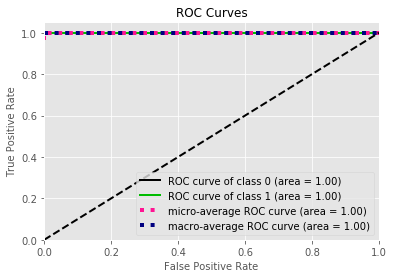

In [33]:
import scikitplot as skplt
skplt.metrics.plot_roc_curve(y_test, y_rfproba)

### Logistic Regression

In [95]:
# lgr_grid = [{'scoring':['accuracy_score','f1_score'], 'refit':[True, False]}]
# gridsearchLR = GridSearchCV(lgr, lgr_grid, cv=8, n_jobs=2, verbose=1)
# gridsearchLR.fit(X_train, y_train)

In [101]:
lgr_0 = LogisticRegressionCV(verbose=2, max_iter=500, cv=8)

In [102]:
lgr_0.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 14.9min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed: 114.5min finished


LogisticRegressionCV(Cs=10, class_weight=None, cv=8, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=500,
           multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
           refit=True, scoring=None, solver='lbfgs', tol=0.0001, verbose=2)

In [103]:
y_lgr, y_lgrproba = lgr_0.predict(X_test), lgr_0.predict_proba(X_test)

In [104]:
print 'test error rate:', 1 - accuracy_score(y_test, y_lgr)
confusion_matrix(y_test, y_lgr)

test error rate: 5.0355763469e-06


array([[185892,      1],
       [     0,  12694]], dtype=int64)

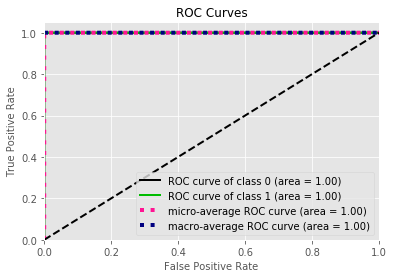

In [105]:
skplt.metrics.plot_roc_curve(y_test, y_lgrproba)

In [54]:
sub_data = pd.read_csv('test_dataset.csv')

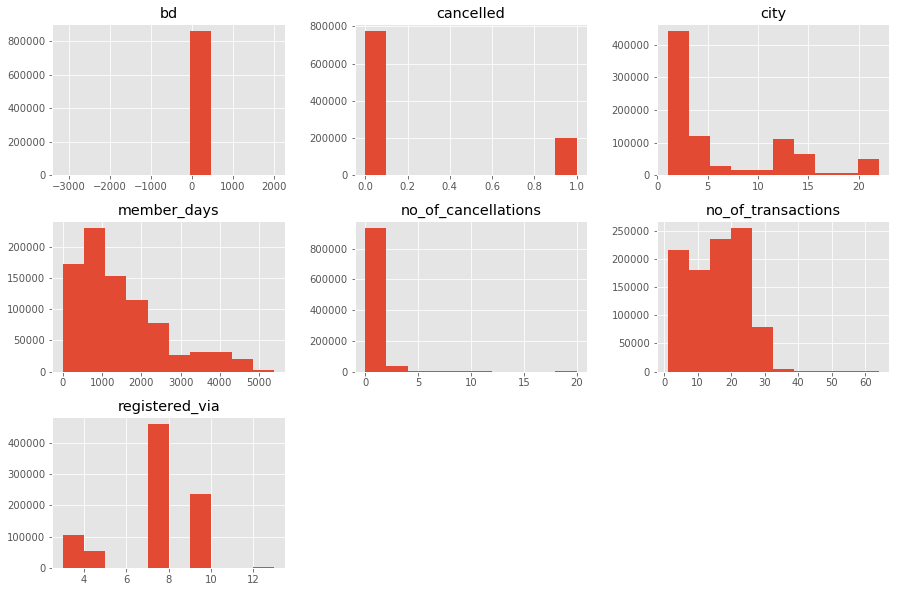

In [58]:
sub_data[members].hist(figsize=(15,10))
plt.show()

In [59]:
sub_data.loc[sub_data['bd'] > 80, 'bd'] = np.nan
sub_data.loc[sub_data['bd'] < 10, 'bd'] = np.nan
sub_data.loc[sub_data['gender'] == 'missing', 'gender'] = np.nan

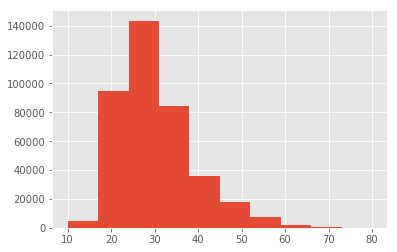

In [60]:
sub_data['bd'].hist()
plt.show()

In [72]:
sub_data.columns[sub_data.isnull().any()]

Index([u'is_auto_renew'], dtype='object')

In [74]:
sub_data[lst] = DataFrameImputer().fit_transform(sub_data[lst])

In [75]:
sub_data[cat_cols] = sub_data[cat_cols].apply(lambda x: d[x.name].transform(x))

In [76]:
sub_data.head(10)

,msno,is_churn,city,bd,gender,registered_via,member_days,no_of_transactions,no_of_cancellations,cancelled,...,plan_days_110,plan_days_200,plan_days_230,plan_days_240,plan_days_270,plan_days_360,plan_days_365,plan_days_395,plan_days_400,plan_days_450
0,+++hVY1rZox/33YtvDgmKA2Frg/2qhkz12B9ylCvh8o=,0,0,28.0,1,2,1195.0,4,0,0,...,0,0,0,0,0,0,0,0,0,0
1,+++l/EXNMLTijfLBa8p2TUVVVp2aFGSuUI/h7mLmthw=,0,13,26.0,1,3,2527.0,19,0,0,...,0,0,0,0,0,0,0,0,0,0
2,+++snpr7pmobhLKUgSHTv/mpkqgBT0tQJ0zQj6qKrqc=,0,0,28.0,1,2,1099.0,26,0,0,...,0,0,0,0,0,0,0,0,0,0
3,++/9R3sX37CjxbY/AaGvbwr3QkwElKBCtSvVzhCBDOk=,0,16,21.0,1,2,571.0,12,0,0,...,0,0,0,0,0,0,0,0,0,0
4,++/UDNo9DLrxT8QVGiDi1OnWfczAdEwThaVyD0fXO50=,0,20,32.0,1,3,2101.0,19,0,0,...,0,0,0,0,0,0,0,0,0,0
5,++/ZHqwUNa7U21Qz+zqteiXlZapxey86l6eEorrak/g=,0,11,39.0,1,0,1087.0,21,0,0,...,0,0,0,0,0,0,0,0,0,0
6,++0/NopttBsaAn6qHZA2AWWrDg7Me7UOMs1vsyo4tSI=,0,0,28.0,1,2,549.0,12,0,0,...,0,0,0,0,0,0,0,0,0,0
7,++0BJXY8tpirgIhJR14LDM1pnaRosjD1mdO1mIKxlJA=,0,0,28.0,1,3,784.0,16,0,0,...,0,0,0,0,0,0,0,0,0,0
8,++0EzISdtKY48Z0GY62jer/LFQwrNIAbADdtU5xStGY=,0,0,28.0,1,0,1401.0,6,0,0,...,0,0,0,0,0,0,0,0,0,0
9,++0nOC7BmrUTtcSboRORfg6ZXTajnBDt1f/SEgH6ONo=,0,11,25.0,1,3,2780.0,7,1,1,...,0,0,0,0,0,0,0,0,0,0


In [78]:
X_val = sub_data.drop(['is_churn', 'msno'], axis=1)

In [83]:
y_rfproba_sub = rf_best.predict_proba(X_val)

[Parallel(n_jobs=2)]: Done  15 out of  15 | elapsed:    1.2s finished


In [84]:
rf_ans = sub_data[['msno', 'city']]
rf_ans['is_churn'] = y_rfproba_sub[:,1]
ans = rf_ans.drop(['city'], axis=1)

C:\Users\Laolu\Anaconda2\envs\py27\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [86]:
ans['is_churn'].value_counts()

0.000000    940567
0.066667     20911
0.133333      5614
0.200000      2468
0.266667       810
0.333333       334
0.400000       117
0.466667        71
0.533333        68
Name: is_churn, dtype: int64

In [87]:
ans.head()

,msno,is_churn
0,+++hVY1rZox/33YtvDgmKA2Frg/2qhkz12B9ylCvh8o=,0.0
1,+++l/EXNMLTijfLBa8p2TUVVVp2aFGSuUI/h7mLmthw=,0.0
2,+++snpr7pmobhLKUgSHTv/mpkqgBT0tQJ0zQj6qKrqc=,0.0
3,++/9R3sX37CjxbY/AaGvbwr3QkwElKBCtSvVzhCBDOk=,0.0
4,++/UDNo9DLrxT8QVGiDi1OnWfczAdEwThaVyD0fXO50=,0.0


In [88]:
ans.to_csv('submission_2.csv', index=False)

In [107]:
y_lgrsub_proba = lgr_0.predict_proba(X_val)

In [108]:
lgr_ans = sub_data[['msno','city']]
lgr_ans['is_churn'] = y_lgrsub_proba[:,1]
l_ans = lgr_ans.drop(['city'], axis=1)
l_ans['is_churn'].value_counts()

C:\Users\Laolu\Anaconda2\envs\py27\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


0.000522    7204
0.000667    6669
0.000793    6610
0.000706    5442
0.000629    5034
0.000840    4935
0.001058    4819
0.001120    4791
0.000561    4586
0.000698    4405
0.000594    4300
0.000748    4176
0.000890    4110
0.001187    3880
0.000837    3823
0.000741    3751
0.001495    3622
0.001627    3370
0.001203    3260
0.001202    3160
0.002394    3141
0.001411    3119
0.000889    3044
0.001531    2987
0.000657    2882
0.000998    2848
0.000698    2726
0.001278    2671
0.000788    2561
0.001442    2492
            ... 
0.000787       1
0.003846       1
0.001222       1
0.006034       1
0.000497       1
0.002599       1
0.000473       1
0.000881       1
0.003299       1
0.001619       1
0.007101       1
0.001625       1
0.003166       1
0.000372       1
0.000295       1
0.000845       1
0.000598       1
0.003260       1
0.001498       1
0.002924       1
0.006145       1
0.002348       1
0.000621       1
0.002318       1
0.000294       1
0.000329       1
0.000866       1
0.000989      

In [109]:
l_ans.head()

,msno,is_churn
0,+++hVY1rZox/33YtvDgmKA2Frg/2qhkz12B9ylCvh8o=,0.001412
1,+++l/EXNMLTijfLBa8p2TUVVVp2aFGSuUI/h7mLmthw=,0.000925
2,+++snpr7pmobhLKUgSHTv/mpkqgBT0tQJ0zQj6qKrqc=,0.000527
3,++/9R3sX37CjxbY/AaGvbwr3QkwElKBCtSvVzhCBDOk=,0.001252
4,++/UDNo9DLrxT8QVGiDi1OnWfczAdEwThaVyD0fXO50=,0.000658


In [110]:
l_ans.to_csv('submission_2lgr.csv', index=False)

**This looks like overfitting...**

**We must split our training set into equal folds and we stratify our folds to ensure both classes 0 & 1 are equally represented across folds**

In [23]:
lgr_1 = LogisticRegressionCV(cv=StratifiedKFold(n_splits=8), refit=True, verbose=1)

In [24]:
lgr_1.fit(X_train, y_train)

C:\Users\Laolu\Anaconda2\envs\py27\lib\site-packages\sklearn\linear_model\logistic.py:718: UserWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number "
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed: 26.5min finished


LogisticRegressionCV(Cs=10, class_weight=None,
           cv=StratifiedKFold(n_splits=8, random_state=None, shuffle=False),
           dual=False, fit_intercept=True, intercept_scaling=1.0,
           max_iter=100, multi_class='ovr', n_jobs=1, penalty='l2',
           random_state=None, refit=True, scoring=None, solver='lbfgs',
           tol=0.0001, verbose=1)

In [25]:
y_pred_1 = lgr_1.predict(X_hold)
print 'Logistic Regression test error rate:', 1 - accuracy_score(y_hold, y_pred_1)

Logistic Regression test error rate: 0.0


In [26]:
confusion_matrix(y_hold, y_pred_1)

array([[185787,      0],
       [     0,  12800]], dtype=int64)

In [27]:
y_proba_1 = lgr_1.predict_proba(X_hold)

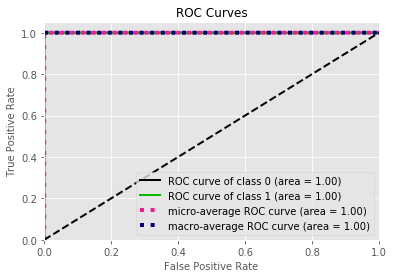

In [28]:
skplt.metrics.plot_roc_curve(y_hold, y_proba_1)

** Non-convergence of our regression coefficients is generally not a good thing... **

Solutions:
- Use a different scoring metric
- Use a different solver
- Increase max_iter
- A combination of the above...

In [ ]:
lgr_3 = LogisticRegressionCV(cv=StratifiedKFold(n_splits=8), refit=True, solver='saga', verbose=1, max_iter=500)
lgr_3.fit(X_train, y_train)

max_iter reached after 982 seconds


C:\Users\Laolu\Anaconda2\envs\py27\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


max_iter reached after 934 seconds
max_iter reached after 931 seconds
max_iter reached after 917 seconds
max_iter reached after 915 seconds
max_iter reached after 915 seconds
max_iter reached after 913 seconds
max_iter reached after 921 seconds
max_iter reached after 910 seconds
max_iter reached after 907 seconds
max_iter reached after 967 seconds
max_iter reached after 983 seconds
max_iter reached after 974 seconds
max_iter reached after 993 seconds
max_iter reached after 921 seconds
max_iter reached after 927 seconds
max_iter reached after 962 seconds
max_iter reached after 979 seconds
max_iter reached after 915 seconds
max_iter reached after 1021 seconds
max_iter reached after 1010 seconds
max_iter reached after 1008 seconds
max_iter reached after 934 seconds
max_iter reached after 960 seconds
max_iter reached after 934 seconds
max_iter reached after 935 seconds
max_iter reached after 954 seconds
max_iter reached after 914 seconds


In [ ]:
y_pred_3 = lgr_3.predict(X_hold)
y_proba_3 = lgr_3.predict_proba(X_hold)
print 'Logistic Regression test error rate:', 1 - accuracy_score(y_hold, y_pred_3)

In [27]:
gridsearchRF.cv_results_

{'mean_fit_time': array([  8.04225001,   8.81687501,   7.85937506,  14.698625  ,
         14.02562496,  14.47587499,  24.31400004,  20.07412499,
         20.59087497,   7.75224996,   7.47925004,   7.94424999,
         14.32937503,  14.18712503,  14.62612495,  21.73525003,
         20.69049999,  20.88037503]),
 'mean_score_time': array([ 0.19837502,  0.19700003,  0.18000001,  0.26975   ,  0.266875  ,
         0.26387498,  0.40837497,  0.33475   ,  0.33262506,  0.18412504,
         0.19674999,  0.18025002,  0.271     ,  0.27149999,  0.28175008,
         0.35237497,  0.37012503,  0.33024997]),
 'mean_test_score': array([ 0.99990055,  0.99984012,  0.99989677,  0.99997356,  0.99997356,
         0.99996979,  0.99999748,  0.99999496,  0.99999874,  0.99987915,
         0.99980865,  0.99989677,  0.99996223,  0.99995342,  0.99998112,
         0.99999496,  0.99999622,  0.99999622]),
 'mean_train_score': array([ 0.99999532,  0.99999227,  0.99999425,  0.99999982,  1.        ,
         0.99999982,  

[[185787      0]
 [     0  12800]]


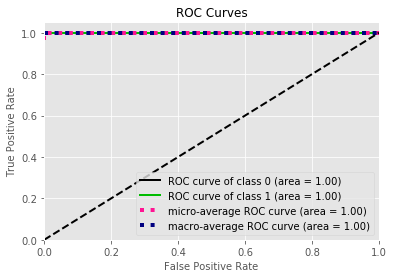

In [30]:
print confusion_matrix(y_hold, y_RF_hold)
skplt.metrics.plot_roc_curve(y_hold, y_RF_proba)

In [66]:
sub_data = pd.read_csv('test_dataset.csv')

In [67]:
sub_data.columns[sub_data.isnull().any()]

Index([u'city', u'bd', u'gender', u'registered_via', u'member_days',
       u'total_amount_paid', u'is_auto_renew'],
      dtype='object')

In [68]:
print len(sub_data['is_auto_renew'])
print sub_data['is_auto_renew'].count()
print sum(sub_data['is_auto_renew'].isnull())

970960
968433
2527


In [71]:
X_val, y_val = sub_data.drop(['is_churn', 'msno'], axis=1), sub_data['is_churn']

In [72]:
y_pred_sub, y_proba_sub = gridsearchRF.best_estimator_.predict(X_val), gridsearchRF.best_estimator_.predict_proba(X_val)

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    2.1s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    2.0s finished
